# Sistema de Ecuaciones Lineales
## Factorización PALU y Cholesky

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy import linalg as spla
from scipy import sparse as scsp
from time import time

## Número de Condición

### Matriz de Hilbert

Matriz cuadrada simétrica y positiva definida, cuyas entradas se definen como:
\begin{equation}
    H_{ij} = \frac{1}{i+j-1}
\end{equation}

Por ejemplo, la matriz $H$ de $5\times 5$ es
\begin{equation}
     H=
     \begin{bmatrix}
         1 & \frac {1}{2} & \frac {1}{3} & \frac {1}{4} & \frac {1}{5}\\
         \frac {1}{2} & \frac {1}{3} & \frac {1}{4} & \frac {1}{5} & \frac {1}{6}\\
         \frac {1}{3} & \frac {1}{4} & \frac {1}{5} & \frac {1}{6} & \frac {1}{7}\\
         \frac {1}{4} & \frac {1}{5} & \frac {1}{6} & \frac {1}{7} & \frac {1}{8}\\
         \frac {1}{5} & \frac {1}{6} & \frac {1}{7} & \frac {1}{8} & \frac {1}{9}
     \end{bmatrix}
\end{equation}

In [2]:
n = 5
H = spla.hilbert(n)

¿Simétrica?

In [3]:
np.all(H == H.T)

True

¿Definida positiva?

In [4]:
np.all(np.linalg.eigvals(H) > 0)

True

Cuidado ver lo que pasa para valores de $n$ grandes.

Número de condición $\kappa(A)$

In [5]:
np.linalg.cond(H), np.max(np.abs(np.linalg.eigvals(H)))/np.min(np.abs(np.linalg.eigvals(H)))

(476607.25024100044, 476607.2502420452)

En teoría esta matriz es simétrica y definida positiva, en la práctica para $n$ grandes no se cumple la ultima propiedad. Además es una matriz mal condicionada. ¿Qué pasará si debemos resolver un sistema de ecuaciones lineales con esta matriz?

# Matriz definida positiva 

Una manera de comprobar si una matriz es definida positiva es calcular los valores propios y comprobar que todos estos sean positivos. Veamos el caso para $n=2$.

In [6]:
np.random.seed(2)
n = 2
A = np.random.rand(n, n)
A = np.dot(A, A.T) + np.eye(n)
eigenvalues = np.linalg.eig(A)[0]
print(eigenvalues)
print(eigenvalues > 0)

[1.0486246  1.63377355]
[ True  True]


La otra forma es comprobar $\mathbf{x}^{T} A \mathbf{x} > 0$, $\mathbf{x}\neq\mathbf{0}$, para eso podemos hacer uso de simpy:

In [7]:
x, y = sym.symbols('x y')
x = np.array([x,y])
f = sym.factor(sym.expand(np.dot(np.dot(x,A),x)))
fl = sym.lambdify(x, f)
f

1.49163442510266*(0.798294611703302*x**2 + 0.336458187477782*x*y + 1.0*y**2)

Si analizamos el polinomio anterior tenemos:

\begin{equation}
    \begin{split}
        0.798294611703302 x^{2} + 0.336458187477782 xy + y^2 & \\
        0.798294611703302 x^{2} + 0.336458187477782 xy + y^2 + 0.028301027980208573x^2 - 0.028301027980208573x^2 & \\
        0.7699935837230933 x^{2} + (0.168229093738891x + y)^{2} &
    \end{split}
\end{equation}

El polinomio es positivo para cualquier valor de $x,y$, entonces estamos en presencia de una matriz definida positiva

Otra idea, pero que podría ser más complicado para $\mathbb{R}^{n}$ con $n>3$, es utilizar el criterio de la segunda derivada (en este caso parcial).

In [8]:
fx = sym.diff(f, x[0]) 
fy = sym.diff(f, x[1])
fxy = sym.diff(fx, x[1])
fyx = sym.diff(fy, x[0])
fxx = sym.diff(fx, x[0])
fyy = sym.diff(fy, x[1])
fxxl = sym.lambdify(x, fxx)
fxyl = sym.lambdify(x, fxy)
fyyl = sym.lambdify(x, fyy)
D = lambda a, b: fxxl(a, b) * fyyl(a, b) - (fxyl(a, b)) ** 2   

In [9]:
fx, fy

(2.38152744838122*x + 0.501872615049506*y,
 0.501872615049506*x + 2.98326885020533*y)

In [10]:
sym.solve([fx, fy])

{y: 0.0, x: 0.0}

In [11]:
D(0, 0), fxxl(0, 0)

(6.852860530928045, 2.38152744838122)

In [12]:
fl(0,0)

0.0

La función tienen un mínimo en $(x,y)=(0,0)$ pero por definición no nos interesa ese punto, así que la función efectivamente es positiva. Por lo tanto $A$ es definida positiva.

# Complejidad temporal y espacial

Estimación del tamaño del arreglo en [MB]

In [13]:
size = lambda a: a.nbytes * 1e-6

In [14]:
Ne = 10 # Repetición de experimentos
Nf = 10 
N = 2 ** np.arange(7, Nf + 1) # N = [2^7, 2^{10}]
Nn = N.shape[-1] 
# Para tiempos
times_palu = np.zeros(Nn)
times_chol = np.zeros(Nn)
# Para espacio
storage_palu = np.zeros(Nn)
storage_chol = np.zeros(Nn)

## Experimentos

In [15]:
for i in range(Nn):
    n = N[i]
    A = np.random.rand(n, n)
    A = np.dot(A, A.T) + np.eye(n)
    # Time PALU
    start_time= time()
    for j in range(Ne):
        P, L, U = spla.lu(A)
    end_time = time()
    storage_palu[i] = size(P) + size(L) + size(U)
    times_palu[i] = (end_time - start_time) / Ne
    # Time Cholesky
    start_time = time()
    for j in range(Ne):
        R = np.linalg.cholesky(A) # R corresponde a R^T 
    end_time = time()
    times_chol[i] = (end_time - start_time) / Ne
    # Storage
    storage_chol[i] = size(R)

## Análisis de tiempo computacional

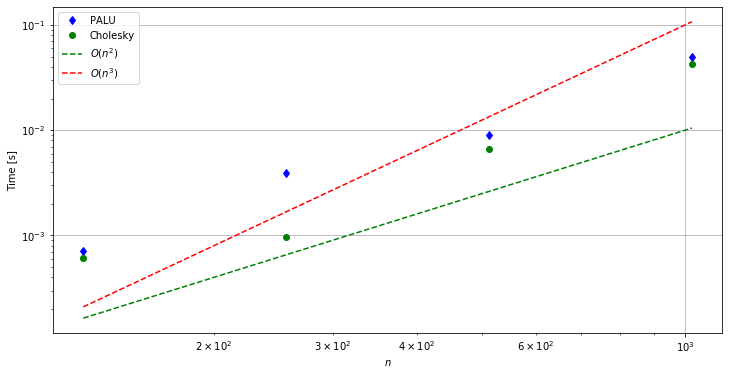

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(N, times_palu, 'bd', label="PALU")
plt.plot(N, times_chol, 'go', label="Cholesky")
# Deben adaptar el coeficiente que acompaña a N**k según los tiempos que obtengan en su computador
plt.plot(N, 1e-8 * N ** 2, 'g--', label=r"$O(n^2)$") 
plt.plot(N, 1e-10 * N ** 3, 'r--', label=r"$O(n^3)$")
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$n$")
plt.ylabel("Time [s]")
plt.legend()
plt.show()

Los algoritmos tienen una complejidad que tiende a $O(n^3)$. Dado que hay optimizaciones en las bibliotecas, pueden ver exponentes menores a $3$. En teoría el análisis debería funcionar para $n\to\infty$.

## Análisis de memoria

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(N, storage_palu, 'bd', label="PALU")
plt.plot(N, storage_chol, 'go', label="Cholesky")
plt.plot(N, 1.5e-5 * N ** 2, 'g-', label=r"$O(n^2)$")
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r"$n$")
plt.ylabel("Size [GB]")
plt.legend()
plt.show()

Si guardamos todos los elementos de las matrices, el espacio utlizado debería ser del orden $\sim n^2$. ¿Existirá una manera de ahorrar espacio?

# Alternativas de almacenamiento

En el caso de $PALU$ debemos almacenar $P$, $L$ y $U$ $\sim 3n^2$. Con Cholesky solo debemos almacenar $\sim n^2$.
Dado que hay muchos elementos iguales a $0$, podríamos almacenar de manera eficiente solo los valores distintos de $0$. Las matrices que tienen muchos valores que son $0$ se conocen como **Sparse Matrix**, *Matriz dispersa o rala* en español. $L$, $U$ y $R$ son matrices triangulares, y $P$ solo tiene $n$ elementos distintos de $0$.

Una matriz triangular, tiene $\displaystyle n^2 - \sum_{i=1}^{n-1}i=n^2 - \frac{n(n-1)}{2}=\frac{n^2+ n}{2}$ elementos. Es decir, con una representación *dispersa*, $PALU$ requiere mantener $n^2 + 2n$ elementos mientras que Cholesky solo requiere $\displaystyle \frac{n^2+ n}{2}$.

## Almacenamiento *Sparse*

### Coordinate list (COO)

Se almacena una lista de tuplas con $(fila, columna, valor)$.

### Compressed sparse row (CSR)

La matriz se almacena por fila. Se mantienen 3 arreglos, $valores$, $indice\_columnas$, $puntero\_fila$. El primer arreglo guarda los valores no nulos, el segundo guarda el índice de la columna donde se encuentra el coeficiente y el último indica qué parte del primer y segundo arreglo corresponde a cada fila.

### Compressed sparse column (CSC)

Análogo al anterior pero se almacena por columnas. Además el segundo arreglo mantiene el $indice\_filas$ y el tercero $puntero\_columna$.

## Ejemplo

In [ ]:
M = np.array([[1, 0, 3, 0], [0, 1, 8, 0], [0, 0, 0, 0], [0, 1, 0, 1]])

In [ ]:
M

### COO

In [ ]:
M_coo = scsp.coo_matrix(M)

In [ ]:
print("Datos:", M_coo.data)
print("Indice filas:", M_coo.row)
print("Indice columnas:", M_coo.col)

### CSR

In [ ]:
M_csr = scsp.csr_matrix(M)

In [ ]:
print("Datos:", M_csr.data)
print("Indice columnas:", M_csr.indices)
print("Puntero filas:", M_csr.indptr)

In [ ]:
for i in range(M_csr.indptr.shape[-1]-1):
    print("Los elementos de la fila %d, se encuentran entre las posiciones [%d, %d) del arreglo de indices" % (i, M_csr.indptr[i], M_csr.indptr[i+1]))

### CSC

In [ ]:
M_csc = scsp.csc_matrix(M)

In [ ]:
print("Datos:", M_csc.data)
print("Indice filas:", M_csc.indices)
print("Puntero columnas:", M_csc.indptr)

In [ ]:
for i in range(M_csc.indptr.shape[-1]-1):
    print("Los elementos de la columna %d, se encuentran entre las posiciones [%d, %d) del arreglo de indices" % (i, M_csc.indptr[i], M_csc.indptr[i+1]))

Los formatos *CSR* y *CSC* necesitan almacenar $2nz+n+1$ elementos distintos de $0$ ($nz$).

## Matrices generadas por los métodos de factorización

In [ ]:
# Para la visualización de las matrices.
def plotMatrix(M):
    # Solo para ver coeficientes distintos de 0, se muestra la magnitud -> log(|M+eps|), eps para evitar el log(0)
    plt.imshow(np.log(np.abs(M+1e-16))) 
    plt.show()

In [ ]:
plotMatrix(A)

## PALU

In [ ]:
plotMatrix(P); plotMatrix(L); plotMatrix(U)

### Matrices densas

In [ ]:
palu_dense = size(P) + size(L) + size(U)
palu_dense

### Matrices dispersas

#### Formato Coordenadas

In [ ]:
Pc = scsp.coo_matrix(P)
Lc = scsp.coo_matrix(L)
Uc = scsp.coo_matrix(U)

In [ ]:
palu_sparse_co = size(Pc.data) + size(Pc.row) + size(Pc.col) + size(Lc.data) + size(Lc.row) + size(Lc.col) + size(Uc.data) + size(Uc.row) + size(Uc.col)
palu_sparse_co

#### Formato Comprimido

In [ ]:
Psr = scsp.csr_matrix(P)
Lsr = scsp.csr_matrix(L)
Usr = scsp.csr_matrix(U)
Psc = scsp.csc_matrix(P)
Lsc = scsp.csc_matrix(L)
Usc = scsp.csc_matrix(U)

In [ ]:
palu_sparse_r = size(Psr.data) + size(Psr.indices) + size(Psr.indptr) + size(Lsr.data) + size(Lsr.indices) + size(Lsr.indptr) + size(Usr.data) + size(Usr.indices) + size(Usr.indptr)
palu_sparse_r

In [ ]:
len(Psr.data)

In [ ]:
palu_sparse_c = size(Psc.data) + size(Psc.indices) + size(Psc.indptr) + size(Lsc.data) + size(Lsc.indices) + size(Lsc.indptr) + size(Usc.data) + size(Usc.indices) + size(Usc.indptr)
palu_sparse_c

% memoria matrices *densas* vs *dispersas* utilizando coordenadas

In [ ]:
palu_sparse_co / palu_dense

% memoria matrices *densas* vs *dispersas* utilizando formato comprimido

In [ ]:
palu_sparse_r / palu_dense

## Cholesky

In [ ]:
plotMatrix(R)

### Matriz densa

In [ ]:
cholesky_dense = size(R)
cholesky_dense

### Matriz dispersa

#### Formato Coordenadas

In [ ]:
Rc = scsp.coo_matrix(R)

#### Formato Comprimido

In [ ]:
Rsr = scsp.csr_matrix(R)

In [ ]:
Rsc = scsp.csc_matrix(R)

Tamaño utilizando representación *sparse*

In [ ]:
cholesky_sparse_co = size(Rc.data) + size(Rc.row) + size(Rc.col)
cholesky_sparse_co

In [ ]:
cholesky_sparse_r = size(Rsr.data) + size(Rsr.indices) + size(Rsr.indptr)
cholesky_sparse_r

In [ ]:
cholesky_sparse_c = size(Rsc.data) + size(Rsc.indices) + size(Rsc.indptr)
cholesky_sparse_c

% de memoria utilizando representación *dispersa* formato coordenadas

In [ ]:
cholesky_sparse_co / cholesky_dense

% memoria utilizando representación *dispersa* comprimida.

In [ ]:
cholesky_sparse_r / cholesky_dense

### Comparación

Si analizamos teóricamente la memoria que podemos ahorrar para ambos tipos de factorizaciones utilizando la representación *sparse* tenemos:

* $PALU$: 
\begin{equation}
    \frac{\text{Representación dispersa}}{\text{Representación densa}}=
    \frac{n^2 + 2n}{3n^2} = \frac{n+2}{3n} = \frac{1}{3} + \frac{2}{3n} 
    \implies \lim_{n\to\infty} \left(\frac{1}{3} + \frac{2}{3n}\right) = \dfrac{1}{3}
\end{equation}

* Cholesky
\begin{equation}
    \frac{\text{Representación dispersa}}{\text{Representación densa}}=
    \frac{\frac{n^2 + n}{2}}{n^2} = \frac{n+1}{2n} = \frac{1}{2} + \frac{1}{2n} 
    \implies \lim_{n\to\infty} \left(\frac{1}{2} + \frac{1}{2n}\right) = \dfrac{1}{2}
\end{equation}

Notar que esto es válido solo si almacenamos los coeficientes distintos de $0$. En la práctica estas representaciones deben guardar información adicional sobre la posición de los elementos, entre otros.

Caso $PALU$ (considerando valores no nulos)

In [ ]:
(Pc.data.shape[-1] + Lc.data.shape[-1] + Uc.data.shape[-1]) / (3 * N[-1] ** 2)

Caso Cholesky (considerando valores no nulos)

In [ ]:
Rc.data.shape[-1] / N[-1] ** 2

Se hace énfasis en que este análisis solo compara los valores de coeficientes, pero no se incluye el tamaño de las estructuras adicionales que requieren estas representaciones.

## Resolución sistema de ecuaciones

### Sistema de ecuaciones lineales

\begin{equation}
  A \mathbf{x} = \mathbf{b}
\end{equation}

### Resolución utilizando $PA=LU$

\begin{equation}
  \begin{split}
    A\, \mathbf{x} & = \mathbf{b} \\
    PA\, \mathbf{x} & = P\,\mathbf{b} \\
    LU\, \mathbf{x} & = P\, \mathbf{b} \\
    L\, \mathbf{c} & = P\, \mathbf{b}
  \end{split}
\end{equation}

Algoritmo:
1. Obtener descomposición PALU: $PA=LU$ 
2. Resolver para $\mathbf{c}$: $L\,\mathbf{c} = P\, \mathbf{b}$
3. Resolver para $\mathbf{x}$: $U\,\mathbf{x} = \mathbf{c}$
4. Retornar $\mathbf{x}$

### Resolución utilizando Cholesky

\begin{equation}
  \begin{split}
    A \, \mathbf{x} & = \mathbf{b} \\
    R^T\,R \,\mathbf{x} & = \mathbf{b}
  \end{split}
\end{equation}

Algoritmo:
1. Obtener descomposición de Cholesky: $A=R^T\,R$
2. Resolver para $\mathbf{c}$: $R^T\mathbf{c} = \mathbf{b}$
3. Resolver para $\mathbf{x}$: $R\,\mathbf{x} = \mathbf{c}$
4. Retornar $\mathbf{x}$

## Ejemplo

¿Cómo se resuelven sistemas utilizando las factorizaciones $PA=LU$ y Cholesky?

In [ ]:
n = 100 # Probar con distintos valores de n
A = np.random.rand(n, n)
A = np.dot(A, A.T) + np.eye(n)
# Luego de probar con la matriz A simétrica y definida positiva, probar con la matriz de Hilbert...
#A = spla.hilbert(n) 

In [ ]:
np.linalg.cond(A)

In [ ]:
x = np.arange(1, n+1) # Solucion 
b = np.dot(A, x)

In [ ]:
#x

In [ ]:
np.all(A == A.T)

In [ ]:
np.all(np.linalg.eigvals(A) > 0)

In [ ]:
x_n = np.linalg.solve(A, b) 

### $PA=LU$

In [ ]:
P, L, U = spla.lu(A)
Pb = np.dot(P.T, b) # Permutacion 
c = spla.solve_triangular(L, Pb, lower=True) # Lc = Pb
x_p = spla.solve_triangular(U, c) # Ux = c

In [ ]:
np.linalg.norm(np.dot(P, np.dot(L, U)) - A) # Verificar que PLU = A

### Cholesky

In [ ]:
R = np.linalg.cholesky(A) # Entrega R^T de acuerdo a nuestras diapositivas
c = spla.solve_triangular(R, b, lower=True) # R^Tc = b
x_c = spla.solve_triangular(R.T, c) # Rx = c

In [ ]:
np.linalg.norm(np.dot(R, R.T) - A) # Veridiar que R^TR = A

In [ ]:
# Descomentar para ver soluciones
#print(x_n)
#print(x_p)
#print(x_c) 

## Backward y Forward Error

Analizar el error de las soluciones...

In [ ]:
backwardError = lambda A, x_c, b: np.linalg.norm(b - np.dot(A, x_c), np.inf)
forwardError  = lambda x, x_c: np.linalg.norm(x - x_c, np.inf)

In [ ]:
backwardError(A, x_n, b), forwardError(x, x_n) # Solver de NumPy

In [ ]:
backwardError(A, x_p, b), forwardError(x, x_p) # PALU

In [ ]:
backwardError(A, x_c, b), forwardError(x, x_c) # Cholesky